In [1]:
import os
os.environ["OMP_PROC_BIND"] = os.environ.get("OMP_PROC_BIND", "true")

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pix_transform.pix_transform import PixTransform
from utils.utils import downsample,align_images
from prox_tv import tvgen
from utils.plots import plot_result

####  load dataset  #############################################################
data_path = "./data/depth_sample_images.npz"

dataset = np.load(data_path)
target_imgs = dataset["target_imgs"].squeeze()
guide_imgs =  dataset["guide_imgs"].squeeze()
dataset.close()

####  define parameters  ########################################################
params = {'img_idxs' : [], # idx images to process, if empty then all of them
            
          'scaling': 8,
          'greyscale': False,
          'channels': -1,
          'bicubic_input': False,
          'spatial_features_input': True,
          'weights_regularizer': [0.0001, 0.001, 0.0001], # spatial color head
          'loss': 'l1',
 
          'optim': 'adam',
          'lr': 0.001,
                  
          'batch_size': 32,
          'iteration': 1024*32*32//32,
                  
          'logstep': 64,
          
          'final_TGV' : False,
          'align': False,
          'delta_PBP': 1,
         }



####### image 0/3 - image idx 0 ########


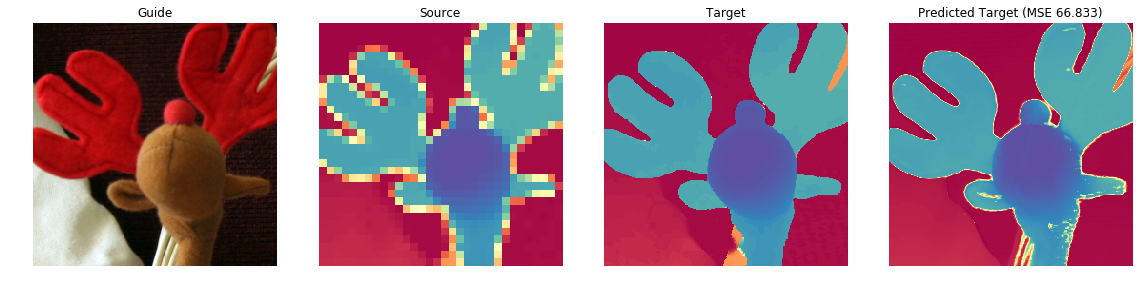

MSE: 66.833  ---  MAE: 2.081  ---  PBP: 0.189



####### image 1/3 - image idx 1 ########


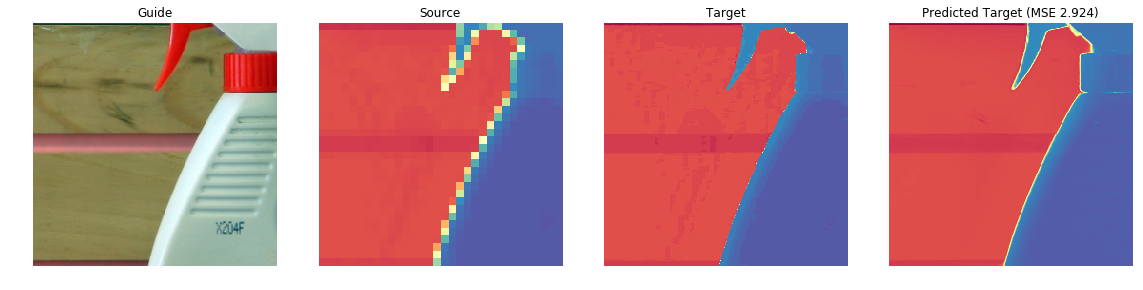

MSE: 2.924  ---  MAE: 0.512  ---  PBP: 0.036



####### image 2/3 - image idx 2 ########


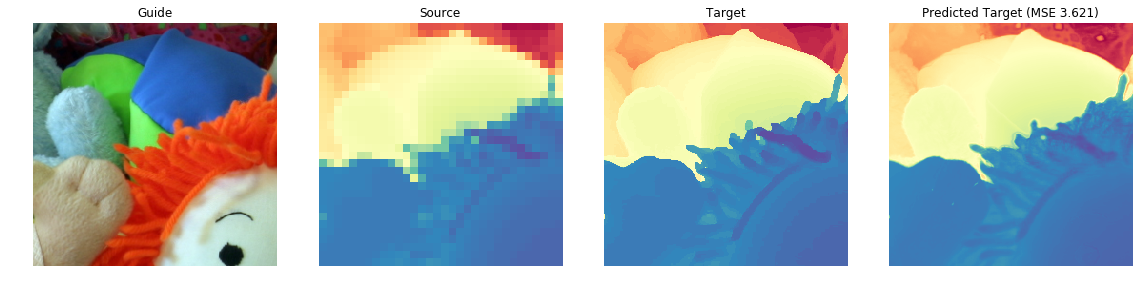

MSE: 3.621  ---  MAE: 0.816  ---  PBP: 0.188





In [2]:
if len(params['img_idxs'])==0:
    idxs = np.array(range(0,target_imgs.shape[0]))
else:
    idxs = params['img_idxs']

for n_image,idx in enumerate(idxs):
    
    print("####### image {}/{} - image idx {} ########".format(n_image+1,len(idxs),idx))
    
    guide_img = guide_imgs[idx]
    target_img = target_imgs[idx]
    source_img = downsample(target_img,params['scaling'])
    
    predicted_target_img = PixTransform(guide_img=guide_img,source_img=source_img,params=params,target_img=target_img)
    
    if params['final_TGV'] :
        print("applying TGV...")
        predicted_target_img = tvgen(predicted_target_img,[0.1, 0.1],[1, 2],[1, 1])
        
    if params['align'] :
        print("aligning...")
        target_img,predicted_target_img = align_images(target_img,predicted_target_img)
        
    
    # compute metrics and plot results
    MSE = np.mean((predicted_target_img - target_img) ** 2)
    MAE = np.mean(np.abs(predicted_target_img - target_img))
    PBP = np.mean(np.abs(predicted_target_img - target_img) > params["delta_PBP"])
    
    
    f, ax = plot_result(guide_img,source_img,target_img,predicted_target_img)
    plt.show()
    
    print("MSE: {:.3f}  ---  MAE: {:.3f}  ---  PBP: {:.3f}".format(MSE,MAE,PBP))
    print("\n\n")

